In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pmdarima as pm
import plotly.express as px
import seaborn as sns

In [2]:
df = pd.read_csv("perrin-freres-monthly-champagne.csv")

In [3]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
df.shape

(107, 2)

In [5]:
df.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [6]:
df.dropna(inplace = True)

In [7]:
df['Month']=pd.to_datetime(df['Month'])

In [8]:
df.set_index('Month',inplace=True)

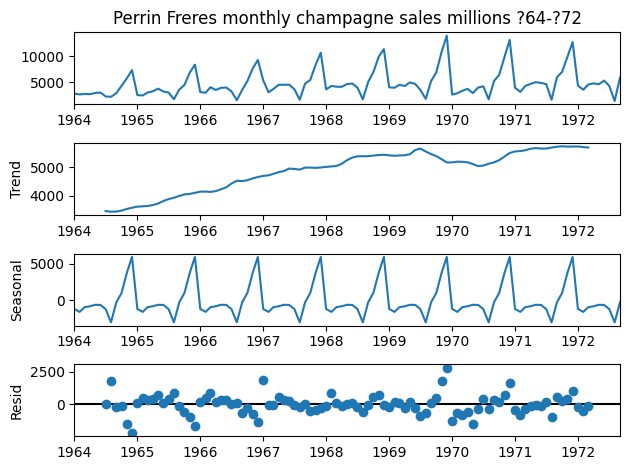

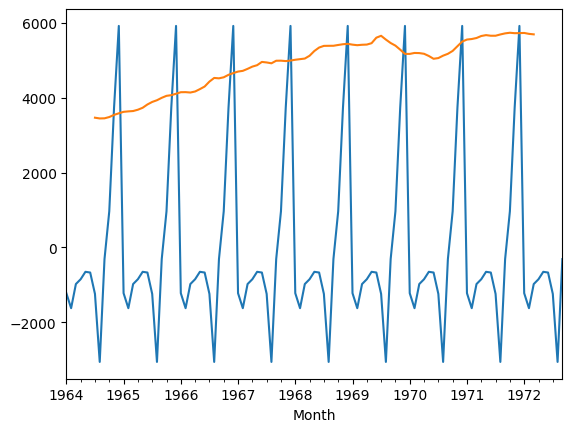

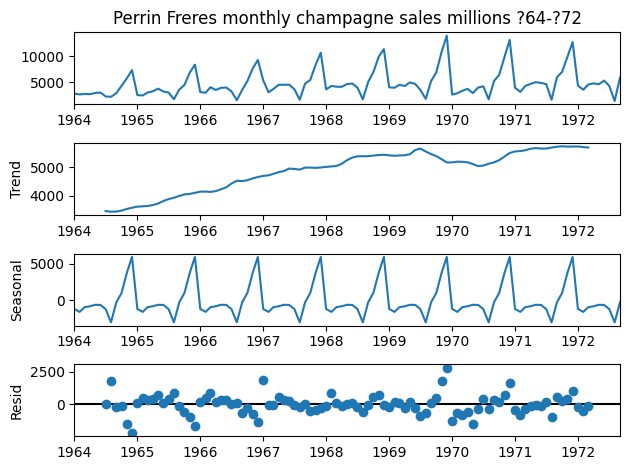

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Perrin Freres monthly champagne sales millions ?64-?72'], model = 'additive', period = 12)
result.seasonal.plot()
result.trend.plot()
result.plot()

In [10]:
def adf(col):
    adf = adfuller(df.loc[:, col].values, autolag = 'AIC')
    print("ADF Statistic:", adf[0])
    print("p-value:", adf[1])
    print("n_lags:", adf[2])
    for key, value in adf[4].items():
        print("Critical values:", key, value)
    if(adf[1]<0.05):
        print("Stationary data")
    else:
        print("Non-stationary data") 

In [11]:
adf('Perrin Freres monthly champagne sales millions ?64-?72')

ADF Statistic: -1.8335930563276195
p-value: 0.3639157716602467
n_lags: 11
Critical values: 1% -3.502704609582561
Critical values: 5% -2.8931578098779522
Critical values: 10% -2.583636712914788
Non-stationary data


<AxesSubplot: xlabel='Month'>

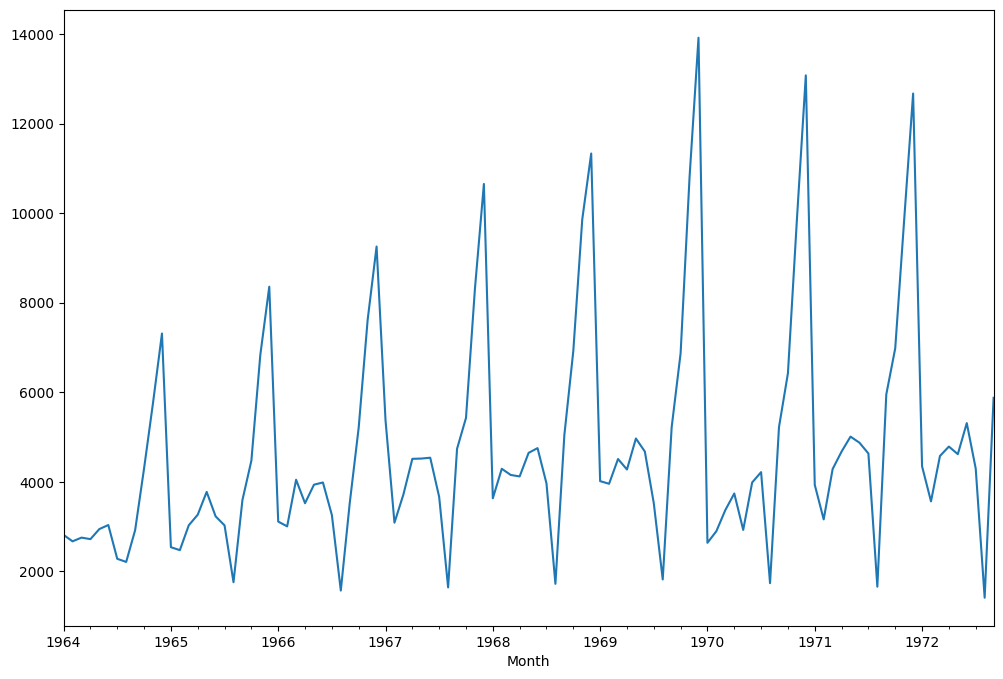

In [12]:
df['Perrin Freres monthly champagne sales millions ?64-?72'].plot(figsize=(12,8))

In [13]:
# df["diff"] = df["Perrin Freres monthly champagne sales millions ?64-?72"].diff(periods=1)

In [14]:
# df.head()

In [15]:
# df = df.dropna()

In [16]:
# results = adfuller(df["diff"].dropna())

In [17]:
# df.plot(figsize=(14, 4))

In [18]:
# adf('diff')

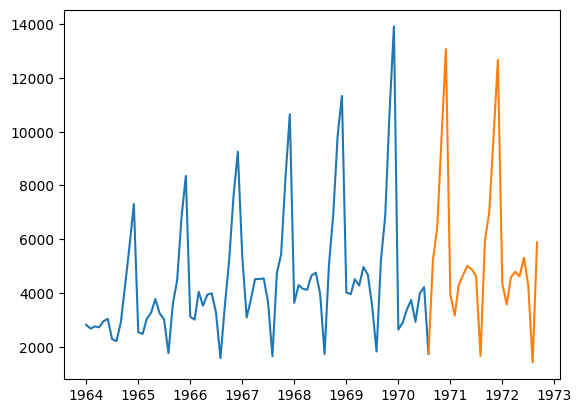

In [19]:
train = df[:80]
test = df[79:]
plt.plot(train)
plt.plot(test)

In [20]:
arima_model = pm.arima.auto_arima(train, d = 1, start_p=0, start_q = 0,
                                  max_p = 5, max_d=5, max_q=5, start_P=0,
                                  D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                                  m=12, season = True, trace = True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True, random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1120.541, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1111.302, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1094.903, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1092.912, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1094.896, Time=0.41 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1093.159, Time=0.17 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1092.954, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1110.917, Time=0.05 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1093.680, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 3.248 seconds


In [21]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   80
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -544.456
Date:                             Fri, 05 May 2023   AIC                           1092.912
Time:                                     14:01:01   BIC                           1097.322
Sample:                                 01-01-1964   HQIC                          1094.657
                                      - 08-01-1970                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8937      0.059    -15.236      0.000      -1.009      -0.779
sigma2      6.043e+05   7.62e+04      7.934      0.000    4.55e+05    7.54e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 5.60
Prob(Q):                              0.69   Prob(JB):                         0.06
Heteroskedasticity (H):               3.14   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods=25), index = test.index)
prediction.columns = ['Predicted sales']
prediction.tail()

,Predicted sales
Month,
1972-05-01,2588.855590
1972-06-01,3647.855590
1972-07-01,3878.855590
1972-08-01,1399.855590
1972-09-01,4714.783384


In [23]:
model_sarima=sm.tsa.statespace.SARIMAX(df['Perrin Freres monthly champagne sales millions ?64-?72'],order=(0, 1, 1),seasonal_order=(1,1,1,12))
model_sarima_fit=model_sarima.fit()

C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot: >

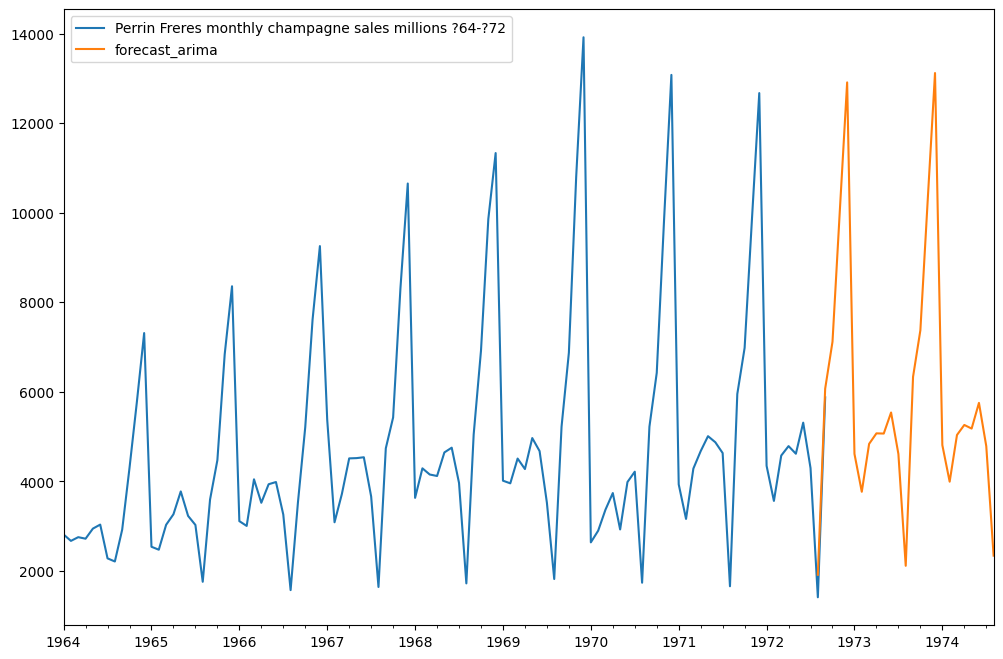

In [24]:
from pandas.tseries.offsets import DateOffset

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df=pd.concat([df,future_datest_df])


future_df['forecast_arima'] = model_sarima_fit.predict(start = 103, end = 3000, dynamic= True)  
future_df[['Perrin Freres monthly champagne sales millions ?64-?72', 'forecast_arima']].plot(figsize=(12, 8))

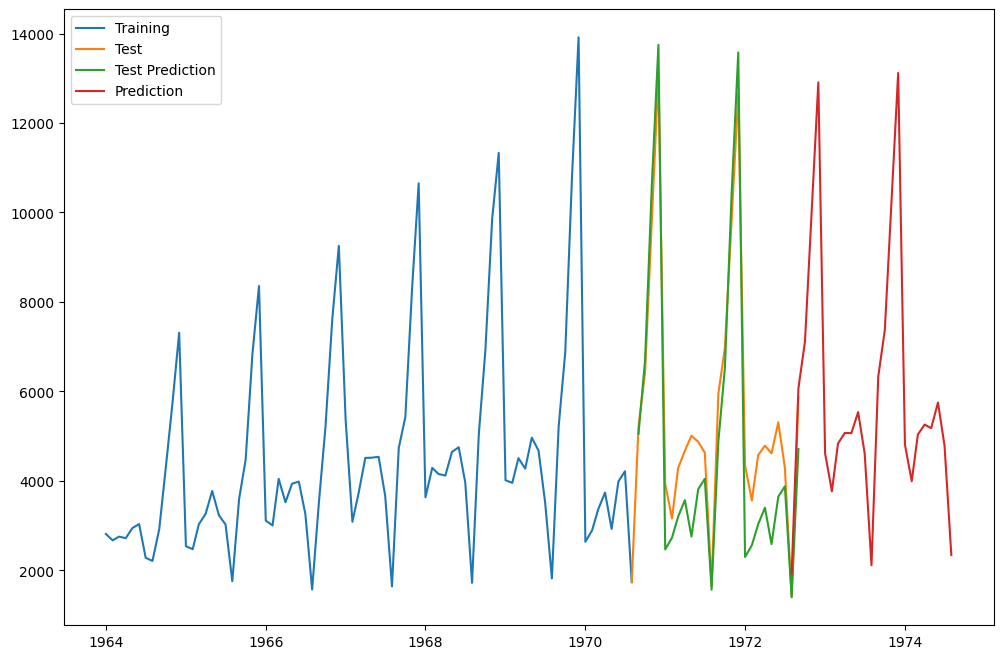

In [25]:
plt.figure(figsize = (12,8))
plt.plot(train, label = "Training")
plt.plot(test, label = "Test")
plt.plot(prediction, label = "Test Prediction")
plt.plot(future_df['forecast_arima'] , label = "Prediction")
plt.legend()
plt.show()

C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


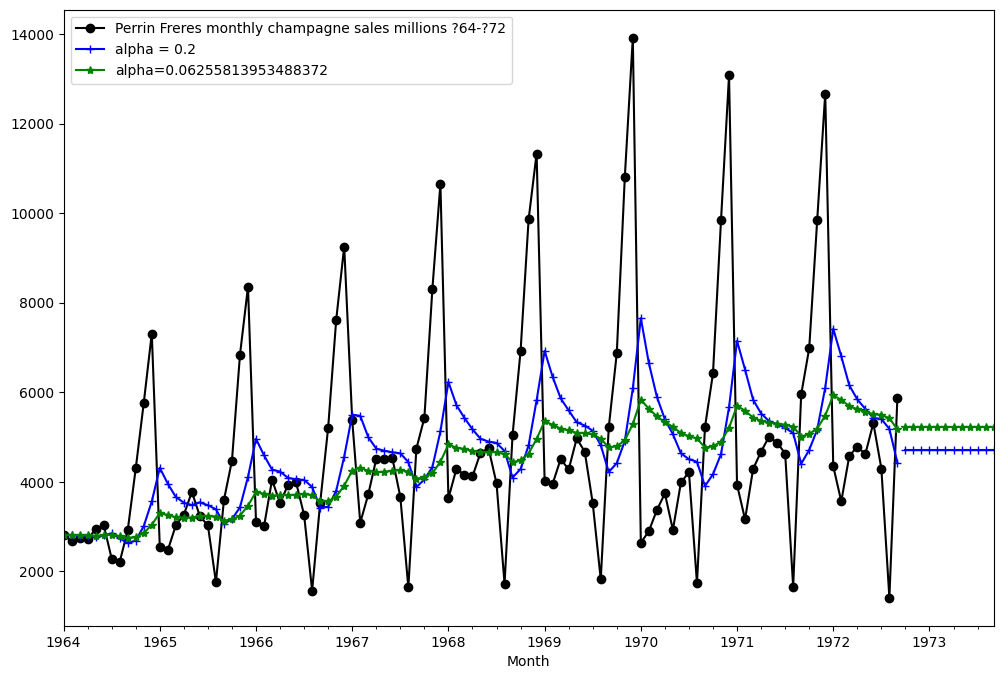

In [26]:
from statsmodels.tsa.api import SimpleExpSmoothing

n = 12
alpha = 0.2

model = SimpleExpSmoothing(df['Perrin Freres monthly champagne sales millions ?64-?72']).fit(smoothing_level = alpha, optimized = False)
forecast1 = model.forecast(n).rename('alpha = ' + str(alpha))

model2 = SimpleExpSmoothing(df['Perrin Freres monthly champagne sales millions ?64-?72']).fit()
forecast2 = model2.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])

ax = df.plot(marker = 'o', color = 'black', figsize=(12,8), legend=True)

forecast1.plot(marker='+', ax=ax, color='blue', legend=True)
model.fittedvalues.plot(marker='+', ax=ax, color='blue')

forecast2.plot(marker='*', ax=ax, color='green', legend=True)
model2.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.show()

C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


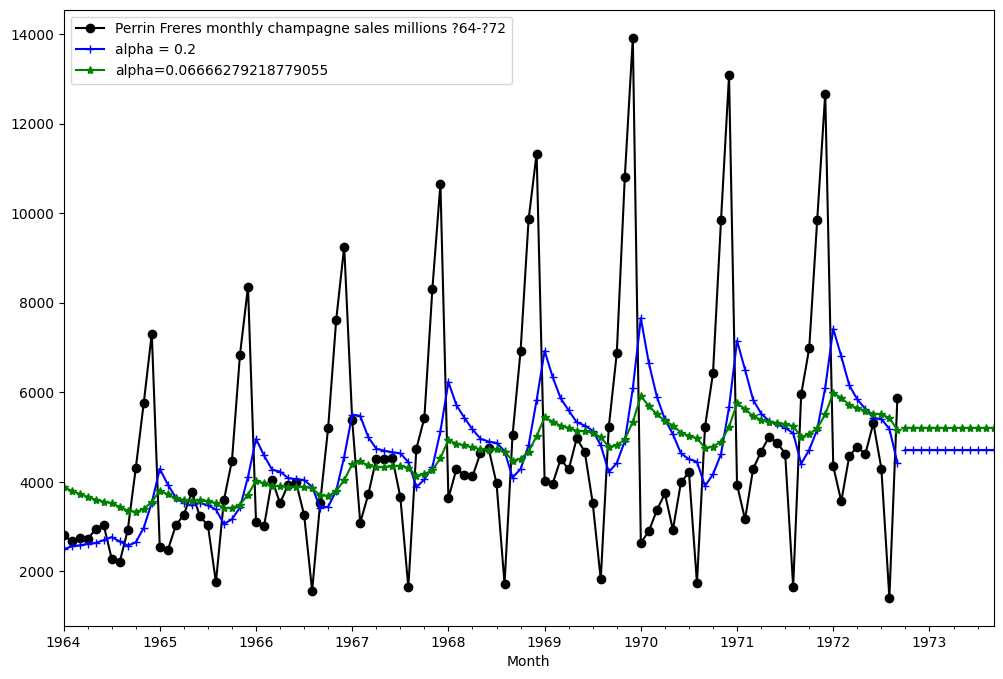

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

n = 12
alpha = 0.2

model = ExponentialSmoothing(df['Perrin Freres monthly champagne sales millions ?64-?72']).fit(smoothing_level = alpha, optimized = False)
forecast1 = model.forecast(n).rename('alpha = ' + str(alpha))

model2 = ExponentialSmoothing(df['Perrin Freres monthly champagne sales millions ?64-?72']).fit()
forecast2 = model2.forecast(n).rename('alpha=%s'%model2.model.params['smoothing_level'])

ax = df.plot(marker = 'o', color = 'black', figsize=(12,8), legend=True)

forecast1.plot(marker='+', ax=ax, color='blue', legend=True)
model.fittedvalues.plot(marker='+', ax=ax, color='blue')

forecast2.plot(marker='*', ax=ax, color='green', legend=True)
model2.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.show()

C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\SV\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


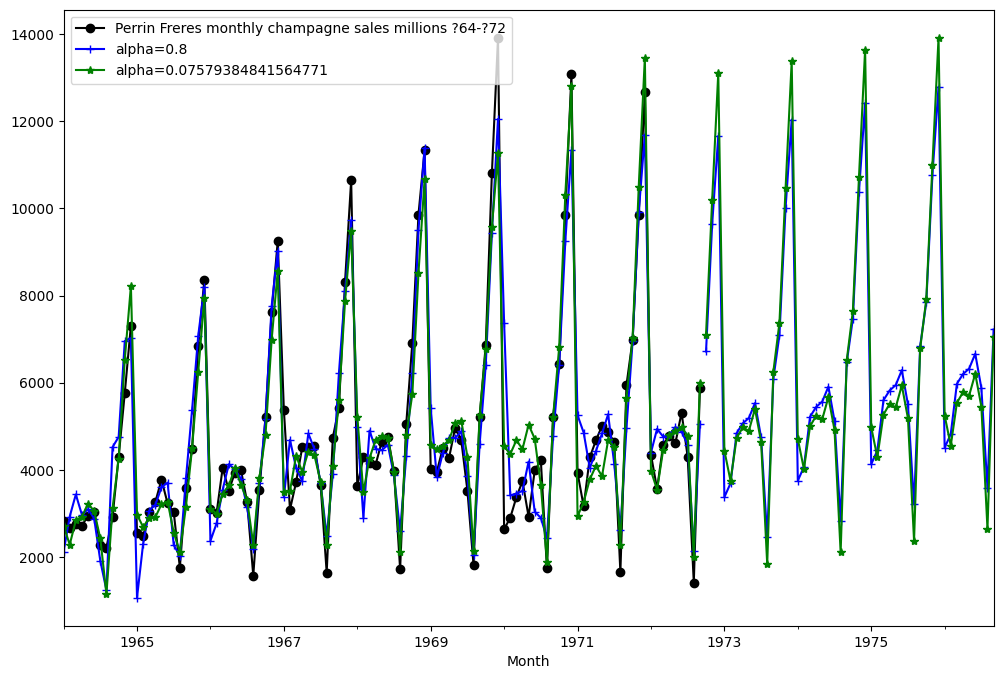

In [28]:
n = 48
alpha = 0.8
trend = 'add'
seasonal = 'mult'
sPeriod = 12

model1 = ExponentialSmoothing(df['Perrin Freres monthly champagne sales millions ?64-?72'], trend, seasonal='add', seasonal_periods=sPeriod).fit(smoothing_level=alpha)
forecast1 = model1.forecast(n).rename('alpha='+str(alpha))

model3 = ExponentialSmoothing(df['Perrin Freres monthly champagne sales millions ?64-?72'], trend, seasonal='add', seasonal_periods=sPeriod).fit()
forecast3 = model3.forecast(n).rename('alpha=%s'%model3.model.params['smoothing_level'])

ax = df.plot(marker='o', color='black', figsize=(12,8), legend=True)
forecast1.plot(marker='+', ax=ax, color='blue', legend=True)
model1.fittedvalues.plot(marker='+', ax=ax, color='blue')
forecast3.plot(marker='*', ax=ax, color='green', legend=True)
model3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.show()
